In [25]:
import pandas as pd

In [26]:
data = pd.read_csv("output.csv", sep=",")
data = data.drop(columns=['date', 'likes'])
data.head()

,username,title,start,end,com
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,"- Stockholm, International]",Where to begin!!!! Denver to Paris flight on A...
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,"- Porto, International]",My first flight from DC to Paris got delayed b...
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,"- Miami, International]",I recently flew with Air France from Tunisia t...
3,Dougie,Disorganised airline],Edinburgh,"- Valletta, Europe]","Rubbish organisation, missed connection due to..."
4,Arash C,Air France Business crew are very rude to othe...,Paris,"- Miami, International]",Rude Cabin Chef AF092.Rude Cabin Chef and crew...


In [27]:
print(f"Taille de data : {len(data)}")
data = data.dropna(how='any')
print(f"Taille de data : {len(data)}")

Taille de data : 12910
Taille de data : 12895


In [28]:
data['end_'] = data['end'].apply(lambda x: x.split(',')[0])
data = data.drop(columns=['end'])
data['end'] = data['end_'].apply(lambda x: x.split('- ')[1])
data = data.drop(columns=['end_'])
data.head()

,username,title,start,com,end
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,Where to begin!!!! Denver to Paris flight on A...,Stockholm
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,My first flight from DC to Paris got delayed b...,Porto
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,I recently flew with Air France from Tunisia t...,Miami
3,Dougie,Disorganised airline],Edinburgh,"Rubbish organisation, missed connection due to...",Valletta
4,Arash C,Air France Business crew are very rude to othe...,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami


In [29]:
data['trajet'] = data['start'] + "-" + data['end']
data.head()

,username,title,start,com,end,trajet
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,Where to begin!!!! Denver to Paris flight on A...,Stockholm,Denver-Stockholm
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,My first flight from DC to Paris got delayed b...,Porto,Washington DC-Porto
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,I recently flew with Air France from Tunisia t...,Miami,Tunis-Miami
3,Dougie,Disorganised airline],Edinburgh,"Rubbish organisation, missed connection due to...",Valletta,Edinburgh-Valletta
4,Arash C,Air France Business crew are very rude to othe...,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami,Paris-Miami


In [30]:
from textblob import TextBlob

def analyser_sentiment(commentaire):
    return TextBlob(commentaire).sentiment.polarity

data['sentiment'] = data['com'].apply(analyser_sentiment)
data.head()

,username,title,start,com,end,trajet,sentiment
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,Where to begin!!!! Denver to Paris flight on A...,Stockholm,Denver-Stockholm,-0.055726
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,My first flight from DC to Paris got delayed b...,Porto,Washington DC-Porto,0.024731
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,I recently flew with Air France from Tunisia t...,Miami,Tunis-Miami,0.453333
3,Dougie,Disorganised airline],Edinburgh,"Rubbish organisation, missed connection due to...",Valletta,Edinburgh-Valletta,-0.062500
4,Arash C,Air France Business crew are very rude to othe...,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami,Paris-Miami,-0.212500


In [31]:
tendances_trajets = data.groupby('trajet').agg(sentiment_moyen=('sentiment', 'mean'), nombre_commentaires=('sentiment', 'size')).reset_index()
tendances_trajets = tendances_trajets[tendances_trajets['nombre_commentaires'] > 10]
tendances_trajets = tendances_trajets.sort_values(by='sentiment_moyen')
print(tendances_trajets)

                    trajet  sentiment_moyen  nombre_commentaires
2518        Paris-San Jose        -0.102587                   14
1667       Mahebourg-Paris        -0.011755                   25
2456           Paris-Milan        -0.004865                   25
1494      London-Mahebourg         0.000406                   13
1260        Istanbul-Paris         0.003764                   16
...                    ...              ...                  ...
546        Bucharest-Paris         0.299645                   31
1130       Guangzhou-Paris         0.300588                   11
2663  Rio de Janeiro-Paris         0.303537                   34
2841           Seoul-Paris         0.309820                   13
280           Beirut-Paris         0.354941                   16

[189 rows x 3 columns]


In [32]:
trajet_counts = data['trajet'].value_counts()
trajets_avec_min_10 = trajet_counts[trajet_counts >= 10].index
df = data[data['trajet'].isin(trajets_avec_min_10)]
print(f"Nombre de lignes restantes après filtrage : {len(df)}")

Nombre de lignes restantes après filtrage : 7967


In [33]:
from transformers import pipeline
from tqdm import tqdm

<ipython-input-34-acf9f7107816>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tranche'] = pd.cut(df['sentiment'], bins=bins, labels=labels, include_lowest=True)


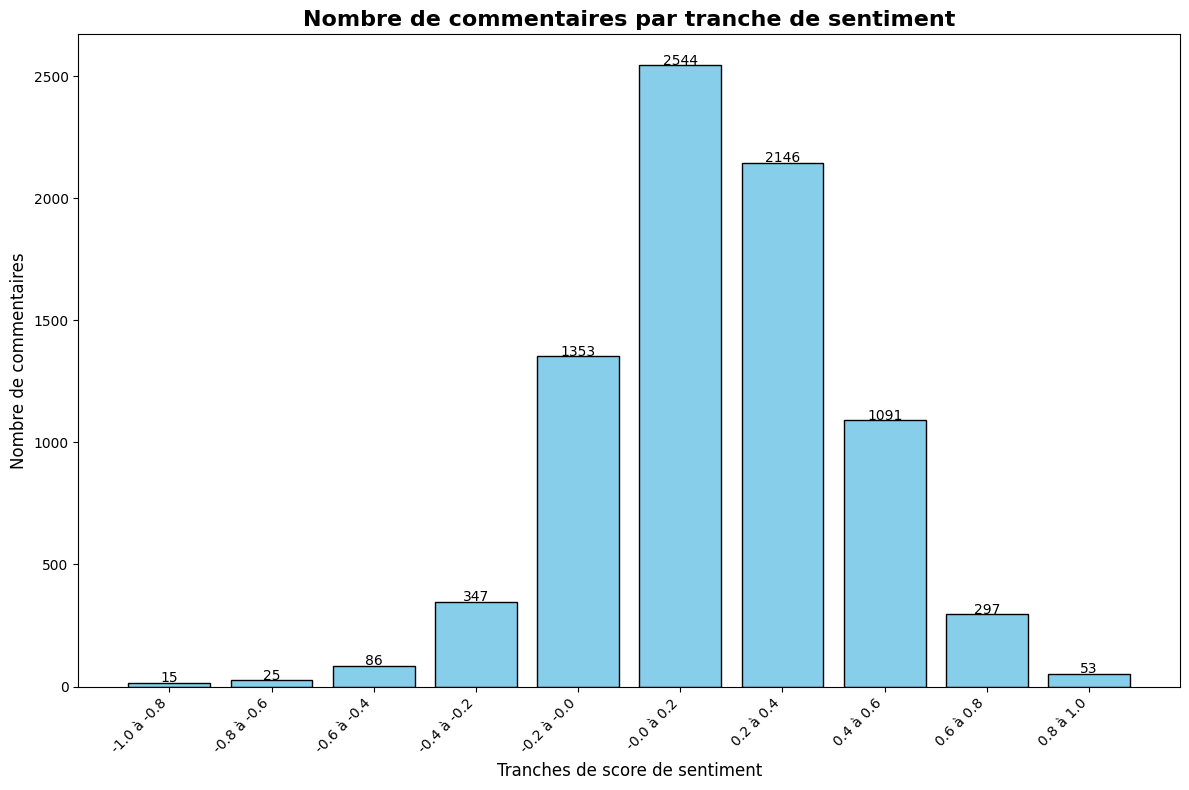

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les tranches de score (-1 à 1 avec un intervalle de 0.2)
bins = np.arange(-1, 1.2, 0.2)
labels = [f"{round(b, 1)} à {round(b + 0.2, 1)}" for b in bins[:-1]]

# Créer une colonne pour les tranches de score
df['tranche'] = pd.cut(df['sentiment'], bins=bins, labels=labels, include_lowest=True)

# Compter le nombre de commentaires par tranche
tranche_counts = df['tranche'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(12, 8))
plt.bar(tranche_counts.index, tranche_counts.values, color='skyblue', edgecolor='black')

# Ajouter des labels et un titre
plt.title("Nombre de commentaires par tranche de sentiment", fontsize=16, weight='bold')
plt.xlabel("Tranches de score de sentiment", fontsize=12)
plt.ylabel("Nombre de commentaires", fontsize=12)

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right', fontsize=10)

# Ajouter des annotations sur les barres
for index, value in enumerate(tranche_counts.values):
    plt.text(index, value + 2, str(value), ha='center', fontsize=10, color='black')

# Ajuster l'affichage
plt.tight_layout()
plt.show()


In [35]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

english_stopwords = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def clean_comment(comment):
    comment = comment.lower()
    comment = re.sub(r'[^\w\s]', '', comment)
    tokens = comment.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in english_stopwords]
    return ' '.join(tokens)
df['cleaned_com'] = df['com'].apply(clean_comment)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
<ipython-input-35-30f8f2473c99>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_com'] = df['com'].apply(clean_comment)


,username,title,start,com,end,trajet,sentiment,tranche,cleaned_com
4,Arash C,Air France Business crew are very rude to othe...,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami,Paris-Miami,-0.212500,-0.4 à -0.2,rude cabin chef af092rude cabin chef crew air ...
7,Jencare,AIR FRANCE LIES ABOUT BUSINESS CLASS TO GET UR...,Paris,You are warned. Paid $3000 one way for Busines...,Los Angeles,Paris-Los Angeles,-0.185544,-0.2 à -0.0,warned paid 3000 one way business class promis...
8,Coddy A,"Elegant ,comfortable, refreshing, delicious fo...",Papeete,It is a rare occasion when you can offer a ful...,Los Angeles,Papeete-Los Angeles,0.163387,-0.0 à 0.2,rare occasion offer fully positive review with...
9,16R25D,"A sickly, cramped and long flight]",Paris,"As we didn’t pay for a seat selection, my tall...",Singapore,Paris-Singapore,0.018015,-0.0 à 0.2,didnt pay seat selection tall husband given mi...
10,Bhawna J,World experience ever],Paris,Worst air lines to travel. On top of the at th...,Mumbai,Paris-Mumbai,-0.150000,-0.2 à -0.0,worst air line travel top crew worst people fi...


In [36]:
df['sentiment2'] = df['cleaned_com'].apply(analyser_sentiment)
tendances_trajets = df.groupby('trajet').agg(sentiment_moyen=('sentiment2', 'mean'), nombre_commentaires=('sentiment2', 'size')).reset_index()
tendances_trajets = tendances_trajets[tendances_trajets['nombre_commentaires'] > 10]
tendances_trajets = tendances_trajets.sort_values(by='sentiment_moyen')
print(tendances_trajets)

                   trajet  sentiment_moyen  nombre_commentaires
152        Paris-San Jose        -0.103215                   14
41         Istanbul-Paris        -0.027401                   16
189        Toulouse-Paris        -0.024662                   11
57        Mahebourg-Paris        -0.020048                   25
132           Paris-Milan        -0.001964                   25
..                    ...              ...                  ...
35        Guangzhou-Paris         0.298881                   11
18        Bucharest-Paris         0.306053                   31
173  Rio de Janeiro-Paris         0.308540                   34
180           Seoul-Paris         0.357908                   13
10           Beirut-Paris         0.391339                   16

[189 rows x 3 columns]


<ipython-input-36-357f7c228ee3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment2'] = df['cleaned_com'].apply(analyser_sentiment)


<ipython-input-37-b4c2386e2eb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tranche2'] = pd.cut(df['sentiment2'], bins=bins, labels=labels, include_lowest=True)


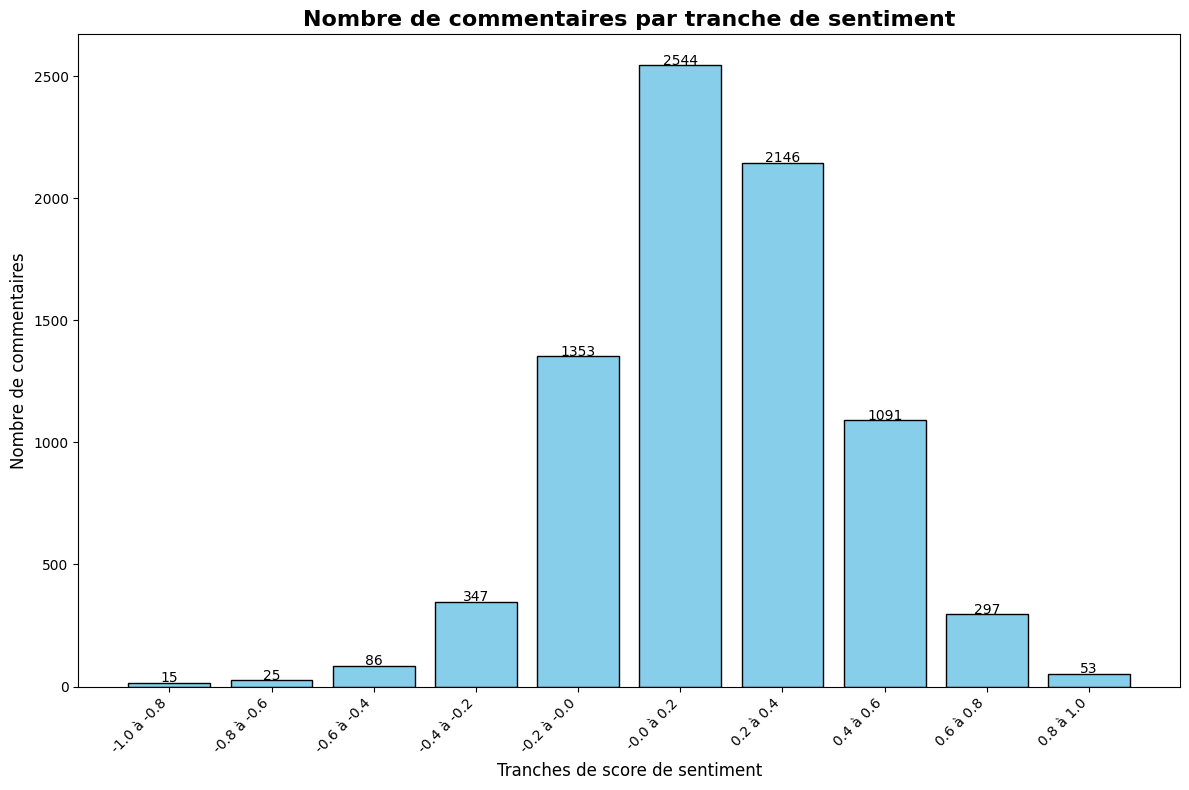

In [37]:
# Définir les tranches de score (-1 à 1 avec un intervalle de 0.2)
bins = np.arange(-1, 1.2, 0.2)
labels = [f"{round(b, 1)} à {round(b + 0.2, 1)}" for b in bins[:-1]]

# Créer une colonne pour les tranches de score
df['tranche2'] = pd.cut(df['sentiment2'], bins=bins, labels=labels, include_lowest=True)

# Compter le nombre de commentaires par tranche
tranche_counts = df['tranche'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(12, 8))
plt.bar(tranche_counts.index, tranche_counts.values, color='skyblue', edgecolor='black')

# Ajouter des labels et un titre
plt.title("Nombre de commentaires par tranche de sentiment", fontsize=16, weight='bold')
plt.xlabel("Tranches de score de sentiment", fontsize=12)
plt.ylabel("Nombre de commentaires", fontsize=12)

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right', fontsize=10)

# Ajouter des annotations sur les barres
for index, value in enumerate(tranche_counts.values):
    plt.text(index, value + 2, str(value), ha='center', fontsize=10, color='black')

# Ajuster l'affichage
plt.tight_layout()
plt.show()

In [38]:
data = pd.read_csv("csvfinal.csv", sep=",")
data = data.drop(columns=['date', 'likes', 'title', 'trajet', 'flight_time', 'start', 'end'])
data

,username,com,distance,start_iata,end_iata,prix_final
0,Arash C,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,7370.231956,CDG,MIA,1686.70
1,Jencare,You are warned. Paid $3000 one way for Busines...,9106.945180,CDG,LAX,1755.68
2,Coddy A,It is a rare occasion when you can offer a ful...,6605.253347,PPT,LAX,1280.00
3,16R25D,"As we didn’t pay for a seat selection, my tall...",10733.752052,CDG,SIN,1134.02
4,Bhawna J,Worst air lines to travel. On top of the at th...,7018.549036,CDG,BOM,843.00
...,...,...,...,...,...,...
7948,Sridhar A,Self-Checked in as one of the first few at NIC...,686.565705,NCE,CDG,196.05
7949,Joycepyl,I was waiting for almost 40 mins on the queue ...,846.423854,VNC,CDG,110.00
7950,Mar C,Nothing outrageous from any other air line. Th...,5852.809977,JFK,CDG,262.83
7951,Oli Rose,Air France is one of my favourite airlines. It...,606.419956,CDG,MAN,146.50


In [40]:
df = df.drop(columns=['title'])
df

,username,start,com,end,trajet,sentiment,tranche,cleaned_com,sentiment2,tranche2
4,Arash C,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami,Paris-Miami,-0.212500,-0.4 à -0.2,rude cabin chef af092rude cabin chef crew air ...,-0.212500,-0.4 à -0.2
7,Jencare,Paris,You are warned. Paid $3000 one way for Busines...,Los Angeles,Paris-Los Angeles,-0.185544,-0.2 à -0.0,warned paid 3000 one way business class promis...,-0.162302,-0.2 à -0.0
8,Coddy A,Papeete,It is a rare occasion when you can offer a ful...,Los Angeles,Papeete-Los Angeles,0.163387,-0.0 à 0.2,rare occasion offer fully positive review with...,0.131450,-0.0 à 0.2
9,16R25D,Paris,"As we didn’t pay for a seat selection, my tall...",Singapore,Paris-Singapore,0.018015,-0.0 à 0.2,didnt pay seat selection tall husband given mi...,-0.032500,-0.2 à -0.0
10,Bhawna J,Paris,Worst air lines to travel. On top of the at th...,Mumbai,Paris-Mumbai,-0.150000,-0.2 à -0.0,worst air line travel top crew worst people fi...,-0.150000,-0.2 à -0.0
...,...,...,...,...,...,...,...,...,...,...
12903,Sridhar A,Nice,Self-Checked in as one of the first few at NIC...,Paris,Nice-Paris,0.158984,-0.0 à 0.2,selfchecked one first nice paid excess baggage...,0.122115,-0.0 à 0.2
12904,Joycepyl,Venice,I was waiting for almost 40 mins on the queue ...,Paris,Venice-Paris,0.441667,0.4 à 0.6,waiting almost 40 min queue check dont know do...,0.378333,0.2 à 0.4
12905,Mar C,New York City,Nothing outrageous from any other air line. Th...,Paris,New York City-Paris,-0.187500,-0.2 à -0.0,nothing outrageous air line staff friendly cho...,-0.312500,-0.4 à -0.2
12906,Oli Rose,Paris,Air France is one of my favourite airlines. It...,Manchester,Paris-Manchester,0.335000,0.2 à 0.4,air france one favourite airline customer care...,0.566667,0.4 à 0.6


In [42]:
result = pd.merge(df, data, on=['username', 'com'], how='inner')
result = result.dropna()
result.head()

,username,start,com,end,trajet,sentiment,tranche,cleaned_com,sentiment2,tranche2,distance,start_iata,end_iata,prix_final
0,Arash C,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami,Paris-Miami,-0.212500,-0.4 à -0.2,rude cabin chef af092rude cabin chef crew air ...,-0.212500,-0.4 à -0.2,7370.231956,CDG,MIA,1686.70
1,Jencare,Paris,You are warned. Paid $3000 one way for Busines...,Los Angeles,Paris-Los Angeles,-0.185544,-0.2 à -0.0,warned paid 3000 one way business class promis...,-0.162302,-0.2 à -0.0,9106.945180,CDG,LAX,1755.68
2,Coddy A,Papeete,It is a rare occasion when you can offer a ful...,Los Angeles,Papeete-Los Angeles,0.163387,-0.0 à 0.2,rare occasion offer fully positive review with...,0.131450,-0.0 à 0.2,6605.253347,PPT,LAX,1280.00
3,16R25D,Paris,"As we didn’t pay for a seat selection, my tall...",Singapore,Paris-Singapore,0.018015,-0.0 à 0.2,didnt pay seat selection tall husband given mi...,-0.032500,-0.2 à -0.0,10733.752052,CDG,SIN,1134.02
4,Bhawna J,Paris,Worst air lines to travel. On top of the at th...,Mumbai,Paris-Mumbai,-0.150000,-0.2 à -0.0,worst air line travel top crew worst people fi...,-0.150000,-0.2 à -0.0,7018.549036,CDG,BOM,843.00


In [43]:
result.to_csv('resultat.csv', index=False, encoding='utf-8')